In [38]:
import pickle 
#import torch
import numpy as np
import plane_fitting as pf
import importlib
importlib.reload(pf)


with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
    
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [39]:
import numpy as np
import pandas as pd
import logging
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.stats import skew

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to center the point cloud
def center_point_cloud(point_cloud):
    #logging.info("Centering point cloud with %d points", len(point_cloud))
    centroid = np.mean(point_cloud[:, :3], axis=0)
    centered_cloud = point_cloud.copy()
    centered_cloud[:, :3] -= centroid  # Subtract the centroid from all points (XYZ only)
    return centered_cloud

# Function to compute the convex hull volume
def compute_convex_hull_volume(point_cloud):
    if len(point_cloud) < 4:  # ConvexHull requires at least 4 non-coplanar points
        logging.warning("Not enough points to compute convex hull volume. Returning 0.")
        return 0.0
    hull = ConvexHull(point_cloud[:, :3])  # Use only XYZ coordinates
    return hull.volume

# Function to compute the density of points
def compute_density(point_cloud):
    volume = compute_convex_hull_volume(point_cloud)
    if volume == 0:
        logging.warning("Convex hull volume is 0. Cannot compute density.")
        return 0.0
    return len(point_cloud) / volume  # Number of points per unit volume

# Function to perform PCA and compute variance ratios, flatness, and elongation
def compute_pca(point_cloud):
    pca = PCA(n_components=3)
    pca.fit(point_cloud[:, :3])  # Use only XYZ coordinates
    variance_ratios = pca.explained_variance_ratio_  # Variance along principal components
    flatness = variance_ratios[1] / variance_ratios[2] if variance_ratios[2] > 0 else 0
    elongation = variance_ratios[0] / variance_ratios[1] if variance_ratios[1] > 0 else 0
    return variance_ratios, flatness, elongation

# Function to compute surface roughness
def compute_surface_roughness(point_cloud, k=10):
    if len(point_cloud) < k:
        logging.warning("Not enough points to compute surface roughness. Returning 0.")
        return 0.0
    neighbors = NearestNeighbors(n_neighbors=k).fit(point_cloud[:, :3])
    _, indices = neighbors.kneighbors(point_cloud[:, :3])
    roughness = []
    
    for idx in indices:
        local_points = point_cloud[idx, :3]  # Use XYZ for local points
        local_pca = PCA(n_components=1)
        local_pca.fit(local_points)
        roughness.append(local_pca.explained_variance_ratio_[0])  # First principal component variance (flatness)
        
    return np.mean(roughness)  # Mean roughness over the point cloud

# Function to compute height variability and vertical skewness
def compute_height_variability(point_cloud):
    z_values = point_cloud[:, 2]  # Extract Z (height) values
    return np.std(z_values), skew(z_values)  # Standard deviation and skewness of the Z values

# Function to compute curvature
def compute_curvature(point_cloud, k=10):
    if len(point_cloud) < k:
        logging.warning("Not enough points to compute curvature. Returning 0.")
        return 0.0
    neighbors = NearestNeighbors(n_neighbors=k).fit(point_cloud[:, :3])
    _, indices = neighbors.kneighbors(point_cloud[:, :3])
    curvatures = []
    
    for idx in indices:
        local_points = point_cloud[idx, :3]
        pca = PCA(n_components=3)
        pca.fit(local_points)
        curvatures.append(pca.explained_variance_ratio_[2])  # Use the smallest principal component variance
        
    return np.mean(curvatures)  # Average curvature

# Function to compute the mean nearest neighbor distance
def compute_mean_nearest_neighbor_distance(point_cloud, k=1):
    if len(point_cloud) <= k:
        logging.warning("Not enough points to compute mean nearest neighbor distance. Returning 0.")
        return 0.0
    neighbors = NearestNeighbors(n_neighbors=k+1).fit(point_cloud[:, :3])  # k+1 because the point itself is the first neighbor
    distances, _ = neighbors.kneighbors(point_cloud[:, :3])
    return np.mean(distances[:, 1:])  # Exclude distance to itself (0)

# Function to compute vertical skewness (Z axis)
#def compute_skewness(point_cloud):
#    z_values = point_cloud[:, 2]  # Z represents height
#    return skew(z_values)  # Measure the skewness along the vertical axis

# Function to compute intensity-based features (mean, std, skewness)
def compute_intensity_features(point_cloud):
    intensities = point_cloud[:, 3]  # Assuming 4th column is intensity
    mean_intensity = np.mean(intensities)
    std_intensity = np.std(intensities)
    skew_intensity = skew(intensities)
    
    return mean_intensity, std_intensity, skew_intensity

def fit_plane_wrapper(point_cloud):
    plane_coef, residuals, skewness =  pf.fit_plane_least_squares(point_cloud[:, :3])
    return plane_coef, residuals, skewness

    

# Combined function to compute all properties for a given point cloud
def compute_pointcloud_properties(point_cloud):
    #logging.info("Computing properties for point cloud with %d points", len(point_cloud))
    
    # Center the point cloud first
    centered_cloud = center_point_cloud(point_cloud)
    plane_coef, residuals, skewness = fit_plane_wrapper(centered_cloud)
    return {
        "number_of_points": len(point_cloud),  # Add the number of points
        "centroid": np.mean(point_cloud[:, :3], axis=0),  # Original centroid before centering
        "convex_hull_volume": compute_convex_hull_volume(centered_cloud),
        "density": compute_density(centered_cloud),
        "pca_variance": compute_pca(centered_cloud),
        "surface_roughness": compute_surface_roughness(centered_cloud),
        "height_variability": compute_height_variability(centered_cloud),
        "curvature": compute_curvature(centered_cloud),
        "mean_nearest_neighbor_distance": compute_mean_nearest_neighbor_distance(centered_cloud),
        "plane_skewness": skewness,
        "intensity_features": compute_intensity_features(centered_cloud),
        "residuals": residuals,
        "plane": plane_coef
    }



In [40]:
# Function to convert point cloud properties into a DataFrame for machine learning
def pointclouds_to_dataframe(point_clouds):
    property_list = []
    
    for i, point_cloud in enumerate(point_clouds):
        #logging.info("Processing point cloud %d", i)
        properties = compute_pointcloud_properties(point_cloud)
        
        # Flatten nested dictionaries (like intensity features)
        flat_properties = {
            **properties,
            "mean_intensity": properties["intensity_features"][0],
            "std_intensity": properties["intensity_features"][1],
            "skew_intensity": properties["intensity_features"][2],
            "plane_a": properties["plane"][0],
            "plane_b": properties["plane"][1],
            "plane_c": properties["plane"][2],
            "plane_d": properties["plane"][3]
            
        }
        del flat_properties["intensity_features"]  # Remove nested dict after flattening
        
        property_list.append(flat_properties)
    
    return pd.DataFrame(property_list)

# Convert X_train and X_test into DataFrames
X_train_df = pointclouds_to_dataframe(X_train)
X_test_df = pointclouds_to_dataframe(X_test)

/var/folders/m4/2f5s5kt17t356vc959c3jdsr0000gn/T/ipykernel_22927/796143852.py:103: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_intensity = skew(intensities)


In [41]:
# Example: Display the first few rows of X_train DataFrame
print(X_train_df.head())

   number_of_points                               centroid  \
0                11   [-116.51889, -127.55576, -4.5829463]   
1                12  [-116.563805, -126.46635, -6.8849754]   
2                11    [-115.31734, -126.51011, -7.384328]   
3                10   [-114.49795, -126.61516, -7.6710043]   
4                12    [-113.44858, -127.34323, -6.335323]   

   convex_hull_volume    density  \
0            0.509615  21.584921   
1            0.677534  17.711295   
2            0.584988  18.803811   
3            1.001776   9.982270   
4            0.733351  16.363240   

                                        pca_variance  surface_roughness  \
0  ([0.9541947, 0.0234421, 0.022363137], 1.048247...           0.941079   
1  ([0.8460805, 0.09844851, 0.05547104], 1.774773...           0.778844   
2  ([0.9232512, 0.05499065, 0.02175815], 2.527358...           0.916832   
3  ([0.8377427, 0.09683623, 0.06542105], 1.480199...           0.837743   
4  ([0.9321016, 0.042372465, 0.0255

In [42]:
# Check the shapes of the individual elements in X_train
shapes = [xi.shape for xi in X_train]

# Print unique shapes
unique_shapes = set(shapes)
print(f"Unique shapes in X_train: {unique_shapes}")


Unique shapes in X_train: {(12, 4), (23, 4), (67, 4), (89, 4), (78, 4), (144, 4), (450, 4), (254, 4), (27, 4), (93, 4), (465, 4), (148, 4), (146, 4), (201, 4), (267, 4), (346, 4), (29, 4), (40, 4), (84, 4), (106, 4), (95, 4), (161, 4), (150, 4), (55, 4), (110, 4), (42, 4), (108, 4), (229, 4), (57, 4), (46, 4), (68, 4), (112, 4), (957, 4), (495, 4), (123, 4), (233, 4), (167, 4), (72, 4), (59, 4), (70, 4), (125, 4), (191, 4), (270, 4), (246, 4), (180, 4), (19, 4), (30, 4), (74, 4), (85, 4), (129, 4), (151, 4), (140, 4), (285, 4), (338, 4), (21, 4), (87, 4), (142, 4), (153, 4), (208, 4), (36, 4), (47, 4), (91, 4), (419, 4), (157, 4), (474, 4), (408, 4), (168, 4), (212, 4), (102, 4), (51, 4), (38, 4), (25, 4), (49, 4), (104, 4), (159, 4), (260, 4), (115, 4), (315, 4), (53, 4), (64, 4), (119, 4), (953, 4), (185, 4), (174, 4), (11, 4), (383, 4), (438, 4), (66, 4), (121, 4), (132, 4), (187, 4), (198, 4), (253, 4), (176, 4), (15, 4), (26, 4), (81, 4), (136, 4), (202, 4), (134, 4), (28, 4), (17

In [43]:
import pandas as pd

# Drop the 'centroid' column
X_train_df_flattened = X_train_df.drop(columns=['centroid'])
X_test_df_flattened = X_test_df.drop(columns=['centroid'])

# Flatten the columns that contain lists or tuples
# For example: 'pca_variance', 'height_variability', etc.
def flatten_column(df, column_name, new_column_names):
    """
    Function to flatten a column containing lists/tuples into multiple columns.
    Args:
    - df: The DataFrame
    - column_name: The column to flatten
    - new_column_names: List of new column names after flattening
    """
    flattened = pd.DataFrame(df[column_name].tolist(), columns=new_column_names, index=df.index)
    df = pd.concat([df.drop(columns=[column_name]), flattened], axis=1)
    return df

# Flattening 'pca_variance', which contains tuples
X_train_df_flattened = flatten_column(X_train_df_flattened, 'pca_variance', ['pca_variance_0', 'pca_variance_1', 'pca_variance_2'])
X_test_df_flattened = flatten_column(X_test_df_flattened, 'pca_variance', ['pca_variance_0', 'pca_variance_1', 'pca_variance_2'])
# Flattening 'height_variability'
X_train_df_flattened = flatten_column(X_train_df_flattened, 'height_variability', ['height_variability_0', 'height_variability_1'])
X_test_df_flattened = flatten_column(X_test_df_flattened, 'height_variability', ['height_variability_0', 'height_variability_1'])

# After flattening, you can now convert the DataFrame into a tensor or use it as input for machine learning models
X_train_flattened = X_train_df_flattened.values  # Convert to NumPy array for further processing
X_test_flattened = X_test_df_flattened.values  # Convert to NumPy array for further processing

In [44]:
# Convert 'pca_variance_0' to numeric, coercing any non-numeric entries to NaN
X_train_df_flattened['pca_variance_0'] = pd.to_numeric(X_train_df_flattened['pca_variance_0'], errors='coerce')
X_train_df_flattened['pca_variance_0'] = X_train_df_flattened['pca_variance_0'].fillna(0)

X_test_df_flattened['pca_variance_0'] = pd.to_numeric(X_test_df_flattened['pca_variance_0'], errors='coerce')
X_test_df_flattened['pca_variance_0'] = X_test_df_flattened['pca_variance_0'].fillna(0)

In [45]:
print(X_train_df_flattened.dtypes)

# If you find any 'object' type columns, those need to be flattened or removed


number_of_points                    int64
convex_hull_volume                float64
density                           float64
surface_roughness                 float32
curvature                         float32
mean_nearest_neighbor_distance    float64
plane_skewness                    float64
residuals                         float64
plane                              object
mean_intensity                    float32
std_intensity                     float32
skew_intensity                    float64
plane_a                           float64
plane_b                           float64
plane_c                           float64
plane_d                           float64
pca_variance_0                    float64
pca_variance_1                    float32
pca_variance_2                    float32
height_variability_0              float32
height_variability_1              float64
dtype: object


In [46]:
try:
    X_train_df_flattened = X_train_df_flattened.drop(columns=['plane'])
    X_test_df_flattened = X_test_df_flattened.drop(columns=['plane'])
except:
    pass
print(X_train_df_flattened.dtypes)

number_of_points                    int64
convex_hull_volume                float64
density                           float64
surface_roughness                 float32
curvature                         float32
mean_nearest_neighbor_distance    float64
plane_skewness                    float64
residuals                         float64
mean_intensity                    float32
std_intensity                     float32
skew_intensity                    float64
plane_a                           float64
plane_b                           float64
plane_c                           float64
plane_d                           float64
pca_variance_0                    float64
pca_variance_1                    float32
pca_variance_2                    float32
height_variability_0              float32
height_variability_1              float64
dtype: object


In [79]:

# Drop rows with missing values from X_train and X_test
X_train_df_flattened_clean = X_train_df_flattened.dropna()
X_test_df_flattened_clean = X_test_df_flattened.dropna()

# Re-align the corresponding target variables using NumPy array indexing
y_train_cleaned = y_train[X_train_df_flattened_clean.index]
y_test_cleaned = y_test[X_test_df_flattened_clean.index]


# Convert the DataFrame to a NumPy array and then to a PyTorch tensor
X_train_flattened_clean = X_train_df_flattened_clean.values
X_test_flattened_clean = X_test_df_flattened_clean.values


In [80]:
# Check if there are NaN values in X_train and X_test
print("Are there any NaN values in X_train?", np.isnan(X_train_flattened_clean).any())
print("Are there any NaN values in X_test?", np.isnan(X_test_flattened_clean).any())
#
## Check if there are infinite values in X_train and X_test
print("Are there any infinite values in X_train?", np.isinf(X_train_flattened_clean).any())
print("Are there any infinite values in X_test?", np.isinf(X_test_flattened_clean).any())


Are there any NaN values in X_train? False
Are there any NaN values in X_test? False
Are there any infinite values in X_train? False
Are there any infinite values in X_test? False


In [81]:
## Remove rows in X_test that contain NaN values
X_test_cleaned = X_test_flattened_clean
y_test_cleaned = y_test_cleaned
X_train_cleaned = X_train_flattened_clean
y_train_cleaned = y_train_cleaned

In [82]:
#print(f"Original shape of X_test: {X_test_flattened.shape}")
print(f"Shape of cleaned X_test: {X_test_cleaned.shape}")
#print(f"Original shape of y_test: {y_test.shape}")
print(f"Shape of cleaned y_test: {y_test_cleaned.shape}")


Shape of cleaned X_test: (4808, 20)
Shape of cleaned y_test: (4808,)


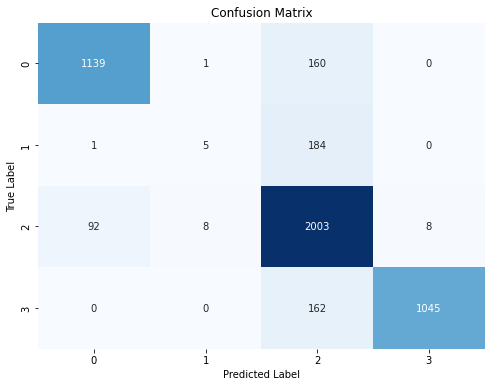

In [83]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = mlp.predict(X_test_cleaned)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_cleaned, y_pred)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


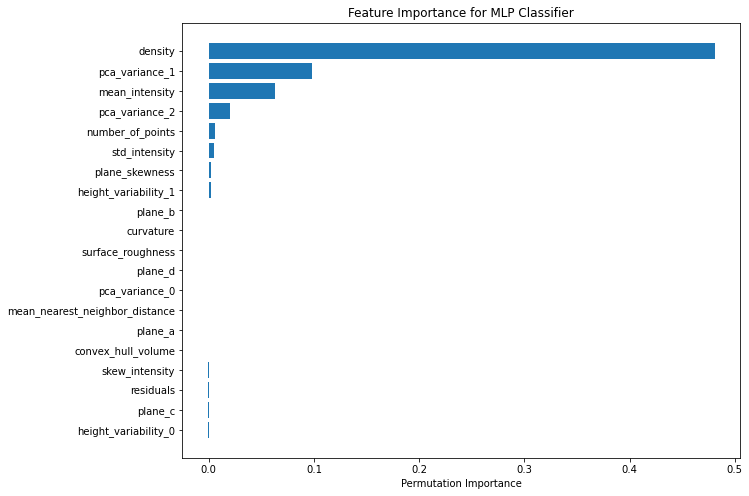

In [84]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(mlp, X_test_cleaned, y_test_cleaned, n_repeats=10, random_state=42, n_jobs=-1)

# Extract the importance of each feature
feature_importances = result.importances_mean

# Create a bar chart to plot feature importance
features = X_train_df_flattened.columns  # Assuming you have the feature names in X_train_df_flattened
sorted_idx = np.argsort(feature_importances)  # Sort by importance

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for MLP Classifier")
plt.show()


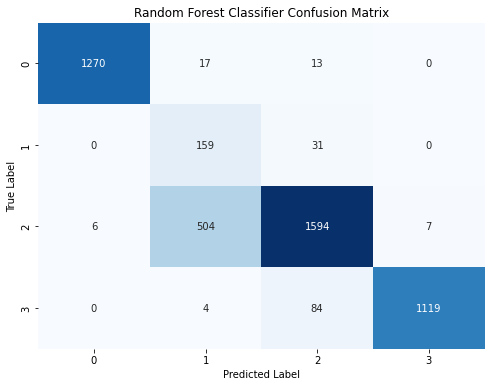

Random Forest Classifier accuracy: 0.86


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_cleaned, y_train_cleaned)


y_pred_rf = rf_clf.predict(X_test_cleaned)

# Step 3: Compute the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_cleaned, y_pred_rf)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Classifier Confusion Matrix')
plt.show()

score = rf_clf.score(X_test_cleaned, y_test_cleaned)
print(f"Random Forest Classifier accuracy: {score:.2f}")


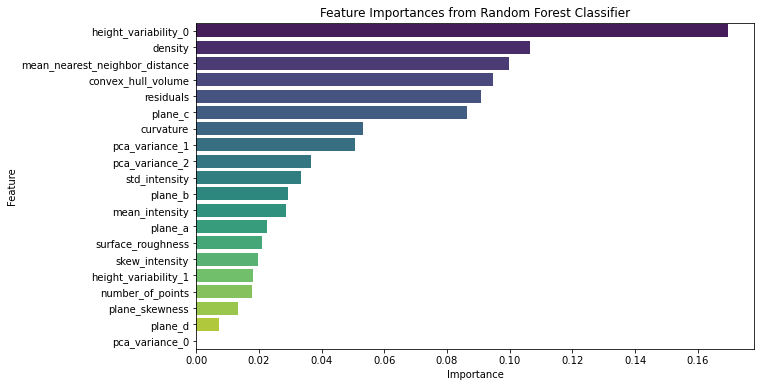

In [86]:
# Use X_train_df_flattened to extract the feature names
feature_names = X_train_df_flattened.columns  # Get the column names from the original DataFrame

# Calculate the importances and sort them
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a dataframe to view feature importances in a cleaner format
feat_importances = pd.DataFrame({
    'Feature': feature_names[indices],  # Use the column names from the DataFrame
    'Importance': importances[indices]
})

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances['Importance'], y=feat_importances['Feature'], palette='viridis')
plt.title('Feature Importances from Random Forest Classifier')
plt.show()



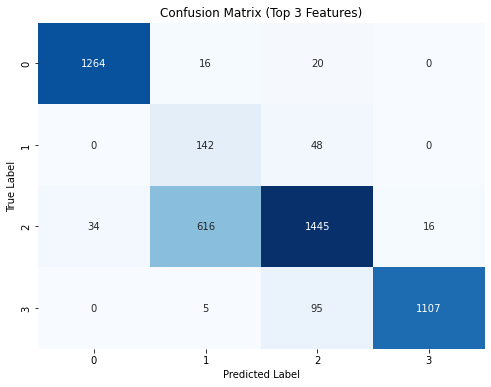

Random Forest Classifier accuracy using top 3 features: 0.82


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 3
top_features = feature_names[indices][:top_n]

X_train_top_features = X_train_df_flattened[top_features].values
X_test_top_features = X_test_df_flattened[top_features].values

rf_clf_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_top.fit(X_train_top_features, y_train_cleaned)

y_pred_top = rf_clf_top.predict(X_test_top_features)

conf_matrix_top = confusion_matrix(y_test_cleaned, y_pred_top)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_top, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Top {top_n} Features)')
plt.show()

score_Nfeat = rf_clf_top.score(X_test_top_features, y_test_cleaned)
print(f"Random Forest Classifier accuracy using top {top_n} features: {score_Nfeat:.2f}")

In [61]:
top_features

Index(['height_variability_0', 'density', 'mean_nearest_neighbor_distance',
       'convex_hull_volume', 'residuals'],
      dtype='object')

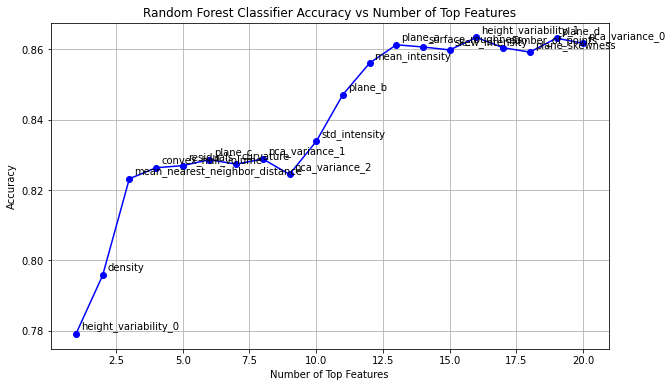

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over different values of N (number of top features)
for N in range(1, len(feature_names) + 1):
    # Select top N most important features
    top_features = feature_names[indices][:N]
    
    # Extract the corresponding columns from the training and test sets
    X_train_top_features = X_train_df_flattened[top_features].values
    X_test_top_features = X_test_df_flattened[top_features].values
    
    # Train a Random Forest Classifier using only the top N features
    rf_clf_top = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf_top.fit(X_train_top_features, y_train_cleaned)
    
    # Evaluate the model on the test set
    score_Nfeat = rf_clf_top.score(X_test_top_features, y_test_cleaned)
    
    # Store the number of features and the accuracy
    n_features_list.append(N)
    accuracy_list.append(score_Nfeat)

# Step 2: Plot the accuracy vs. number of top features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the name of the feature added at that point
for i, txt in enumerate(feature_names[indices][:len(n_features_list)]):
    plt.annotate(txt, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Top Features')
plt.grid(True)
plt.show()


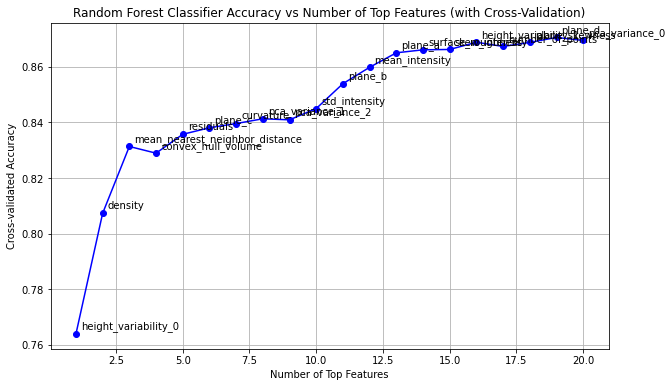

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over different values of N (number of top features)
for N in range(1, len(feature_names) + 1):
    # Select top N most important features
    top_features = feature_names[indices][:N]
    
    # Extract the corresponding columns from the training and test sets
    X_train_top_features = X_train_df_flattened[top_features].values
    X_test_top_features = X_test_df_flattened[top_features].values
    
    # Train a Random Forest Classifier using only the top N features with cross-validation
    rf_clf_top = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_clf_top, X_train_top_features, y_train_cleaned, cv=5, scoring='accuracy')
    
    # Calculate the average cross-validation score
    avg_score = np.mean(cv_scores)
    
    # Store the number of features and the accuracy
    n_features_list.append(N)
    accuracy_list.append(avg_score)

# Step 2: Plot the accuracy vs. number of top features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the name of the feature added at that point
for i, txt in enumerate(feature_names[indices][:len(n_features_list)]):
    plt.annotate(txt, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Top Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Top Features (with Cross-Validation)')
plt.grid(True)
plt.show()


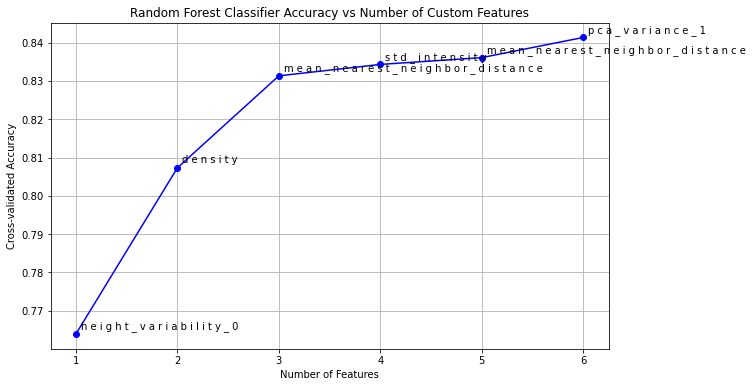

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Your custom list of features (in the order you want to test)
custom_features_list = [
    ['height_variability_0'],  # Just an example, replace with actual feature names
    ['height_variability_0', 'density'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance', 'std_intensity'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance', 'std_intensity', 'mean_nearest_neighbor_distance'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance', 'std_intensity', 'mean_nearest_neighbor_distance', 'pca_variance_1'],
    
    # Add more combinations of features you want to test
]

# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over each custom feature subset
for feature_subset in custom_features_list:
    # Extract the corresponding columns from the training and test sets
    X_train_custom_features = X_train_df_flattened[feature_subset].values
    X_test_custom_features = X_test_df_flattened[feature_subset].values
    
    # Step 2: Train a Random Forest Classifier using only the custom features with cross-validation
    rf_clf_custom = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_clf_custom, X_train_custom_features, y_train_cleaned, cv=5, scoring='accuracy')
    
    # Step 3: Calculate the average cross-validation score
    avg_score = np.mean(cv_scores)
    
    # Store the number of features and the accuracy
    n_features_list.append(len(feature_subset))  # Track how many features were used
    accuracy_list.append(avg_score)  # Store the accuracy for this feature subset

# Step 4: Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the feature names that were used
for i, feature_subset in enumerate(custom_features_list):
    feature_str = ' '.join(feature_subset[i])
    plt.annotate(feature_str, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Custom Features')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Your custom list of features (in the order you want to test)
custom_features_list = [
    ['height_variability_0'],  # Just an example, replace with actual feature names
    ['height_variability_0', 'density'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance', 'std_intensity'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance', 'std_intensity', 'mean_nearest_neighbor_distance'],
    ['height_variability_0', 'density', 'mean_nearest_neighbor_distance', 'std_intensity', 'mean_nearest_neighbor_distance', 'pca_variance_1'],
    
    # Add more combinations of features you want to test
]

# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over each custom feature subset
for feature_subset in custom_features_list:
    # Extract the corresponding columns from the training and test sets
    X_train_custom_features = X_train_df_flattened[feature_subset].values
    X_test_custom_features = X_test_df_flattened[feature_subset].values
    
    # Step 2: Train a Random Forest Classifier using only the custom features with cross-validation
    rf_clf_custom = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_clf_custom, X_train_custom_features, y_train_cleaned, cv=5, scoring='accuracy')
    
    # Step 3: Calculate the average cross-validation score
    avg_score = np.mean(cv_scores)
    
    # Store the number of features and the accuracy
    n_features_list.append(len(feature_subset))  # Track how many features were used
    accuracy_list.append(avg_score)  # Store the accuracy for this feature subset

# Step 4: Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the feature names that were used
for i, feature_subset in enumerate(custom_features_list):
    feature_str = ' '.join(feature_subset[i])
    plt.annotate(feature_str, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Custom Features')
plt.grid(True)
plt.show()


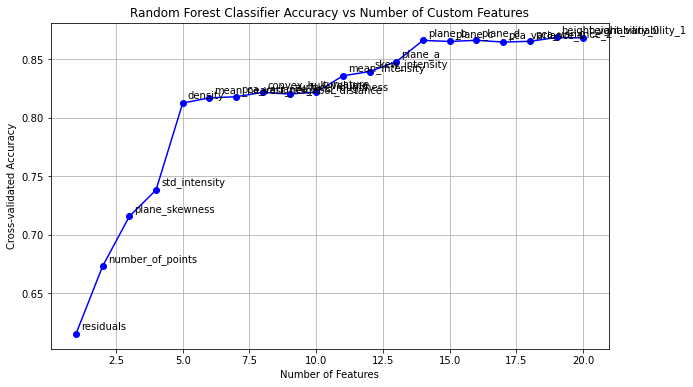

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Your custom list of features (in the order you want to test)
custom_features_list = [
    'residuals', 
    'number_of_points', 
    'plane_skewness', 
    'std_intensity', 
    'density', 
    'mean_nearest_neighbor_distance', 
    'pca_variance_1'
    ]

feature_names

custom_features_list = list(dict.fromkeys(custom_features_list + feature_names.tolist()))
# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over each custom feature subset
for i in range(len(custom_features_list)):
    feature_subset = custom_features_list[:i+1]
    # Extract the corresponding columns from the training and test sets
    X_train_custom_features = X_train_df_flattened[feature_subset].values
    X_test_custom_features = X_test_df_flattened[feature_subset].values
    
    # Step 2: Train a Random Forest Classifier using only the custom features with cross-validation
    rf_clf_custom = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_clf_custom, X_train_custom_features, y_train_cleaned, cv=5, scoring='accuracy')
    
    # Step 3: Calculate the average cross-validation score
    avg_score = np.mean(cv_scores)
    
    # Store the number of features and the accuracy
    n_features_list.append(len(feature_subset))  # Track how many features were used
    accuracy_list.append(avg_score)  # Store the accuracy for this feature subset

# Step 4: Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the feature names that were used
for i, feature_subset in enumerate(custom_features_list):
    feature_str = str(feature_subset)
    plt.annotate(feature_str, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Custom Features')
plt.grid(True)
plt.show()


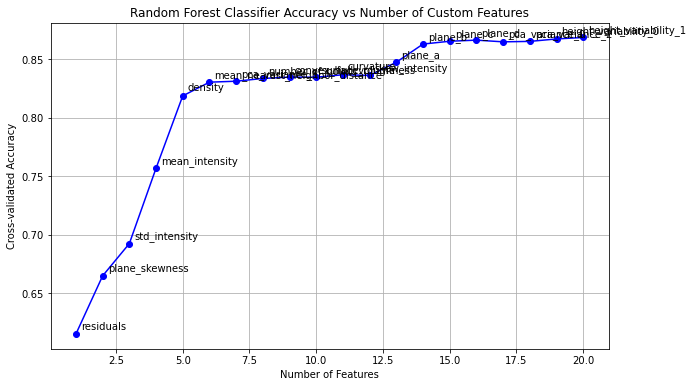

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Your custom list of features (in the order you want to test)
custom_features_list = [
    'residuals', 
    'plane_skewness', 
    'std_intensity', 
    'mean_intensity',
    'density', 
    'mean_nearest_neighbor_distance', 
    'pca_variance_1'
    ]

feature_names

custom_features_list = list(dict.fromkeys(custom_features_list + feature_names.tolist()))
# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over each custom feature subset
for i in range(len(custom_features_list)):
    feature_subset = custom_features_list[:i+1]
    # Extract the corresponding columns from the training and test sets
    X_train_custom_features = X_train_df_flattened[feature_subset].values
    X_test_custom_features = X_test_df_flattened[feature_subset].values
    
    # Step 2: Train a Random Forest Classifier using only the custom features with cross-validation
    rf_clf_custom = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_clf_custom, X_train_custom_features, y_train_cleaned, cv=5, scoring='accuracy')
    
    # Step 3: Calculate the average cross-validation score
    avg_score = np.mean(cv_scores)
    
    # Store the number of features and the accuracy
    n_features_list.append(len(feature_subset))  # Track how many features were used
    accuracy_list.append(avg_score)  # Store the accuracy for this feature subset

# Step 4: Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the feature names that were used
for i, feature_subset in enumerate(custom_features_list):
    feature_str = str(feature_subset)
    plt.annotate(feature_str, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Custom Features')
plt.grid(True)
plt.show()


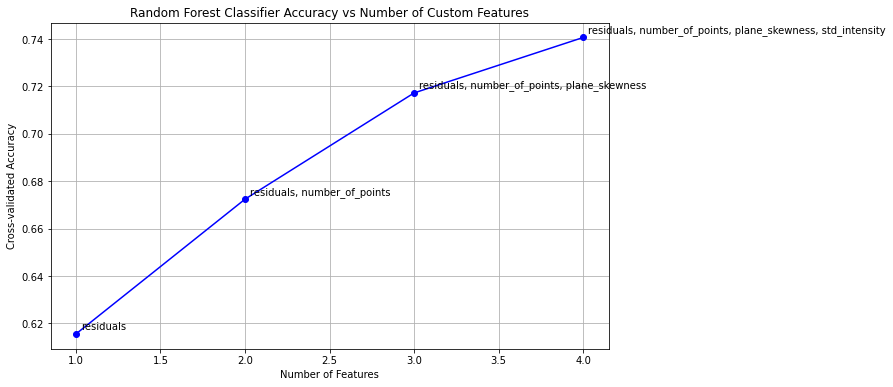

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Your custom list of features (in the order you want to test)
custom_features_list = [
    ['residuals'],
    ['residuals', 'number_of_points'],
    ['residuals', 'number_of_points', 'plane_skewness'],
    ['residuals', 'number_of_points', 'plane_skewness', 'std_intensity'],
    ['residuals', 'number_of_points', 'plane_skewness', 'std_intensity', 'std_density'],
    []
    # Add more combinations of features you want to test
]

# List to store the number of features and their corresponding accuracy
n_features_list = []
accuracy_list = []

# Step 1: Iterate over each custom feature subset
for feature_subset in custom_features_list:
    # Extract the corresponding columns from the training and test sets
    X_train_custom_features = X_train_df_flattened[feature_subset].values
    X_test_custom_features = X_test_df_flattened[feature_subset].values
    
    # Step 2: Train a Random Forest Classifier using only the custom features with cross-validation
    rf_clf_custom = RandomForestClassifier(n_estimators=1000, random_state=42)
    cv_scores = cross_val_score(rf_clf_custom, X_train_custom_features, y_train_cleaned, cv=5, scoring='accuracy')
    
    # Step 3: Calculate the average cross-validation score
    avg_score = np.mean(cv_scores)
    
    # Store the number of features and the accuracy
    n_features_list.append(len(feature_subset))  # Track how many features were used
    accuracy_list.append(avg_score)  # Store the accuracy for this feature subset

# Step 4: Plot the accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracy_list, marker='o', linestyle='-', color='b')

# Label each point with the feature names that were used
for i, feature_subset in enumerate(custom_features_list):
    feature_str = ', '.join(feature_subset)
    plt.annotate(feature_str, (n_features_list[i], accuracy_list[i]), xytext=(5, 5), textcoords='offset points')

# Customize plot
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated Accuracy')
plt.title('Random Forest Classifier Accuracy vs Number of Custom Features')
plt.grid(True)
plt.show()


# 1 Train and test on differnent PCs  
# 2 All points (whart happends with mixed labels voxels) 
# 3 More labels (obstacle_bin, )
# 4 Validation on diffenret dataset